<a href="https://colab.research.google.com/github/CagataySencan/TrafficSignRecognition/blob/main/Traffic_Sign_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gerekli Kütüphanelerin Eklenmesi

In [71]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import  PIL
from sklearn.preprocessing import LabelEncoder
from PIL import  ImageEnhance , ImageOps , Image
from matplotlib import pyplot
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sbn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Verisetini Kaggle'dan Çekmek İçin Gerekli İşlemler


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [4]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
! unzip gtsrb-german-traffic-sign.zip

# Veri Önişleme Aşamaları


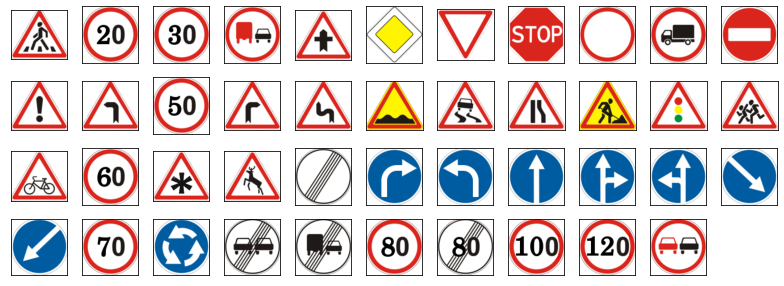

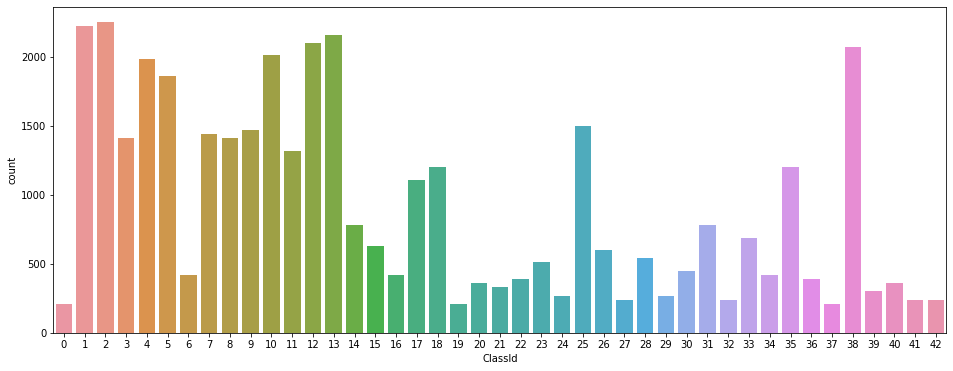

In [2]:
trainDatas = pd.DataFrame(pd.read_csv('Train.csv'))
testDatas = pd.DataFrame(pd.read_csv('Test.csv'))
metaDatas = pd.read_csv('Meta.csv')
allDatas = pd.concat((trainDatas,testDatas),sort = False).reset_index(drop = True)
classCount = len(trainDatas['ClassId'].value_counts())
classes = { 0:'Hız Limiti (20km/s)',
            1:'Hız Limiti (30km/s)', 
            2:'Hız Limiti (50km/s)', 
            3:'Hız Limiti (60km/s)', 
            4:'Hız Limiti (70km/s)', 
            5:'Hız Limiti (80km/s)', 
            6:'Hız Limitinin bitişi (80km/s)', 
            7:'Hız Limiti (100km/s)', 
            8:'Hız Limiti (120km/s)', 
            9:'Geçiş yok', 
            10:'Ağırlığı 3.5 ton üstü olan araçlar geçemez', 
            11:'Kavşakta geçiş hakkı', 
            12:'Öncelikli yol', 
            13:'Yol ver', 
            14:'Dur', 
            15:'Araç giremez', 
            16:'3.5 Ton üzeri araçlar yasak', 
            17:'Giriş yok', 
            18:'Genel uyarı', 
            19:'Sola tehlikeli viraj', 
            20:'Sağa tehlikeli viraj', 
            21:'Sağa tehlikeli devamlı virajlar', 
            22:'Engebeli yol', 
            23:'Kaygan yol', 
            24:'Sağdan daralan yol', 
            25:'Yol çalışması', 
            26:'Trafik işaretleri', 
            27:'Yaya geçidi', 
            28:'Okul geçidi', 
            29:'Bisiklet yolu', 
            30:'Buzlanmaya dikkat',
            31:'Vahşi hayvan çıkabilir', 
            32:'Hız sınırı sonu', 
            33:'Sadece sağa dönüş var', 
            34:'Sadece sola dönüş var', 
            35:'Dönüş yok', 
            36:'Sola dönüş yok', 
            37:'Sağa dönüş yok', 
            38:'Sağdan gidin', 
            39:'Soldan gidin', 
            40:'Dönüş önceliği', 
            41:'Geçiş olmayan yolun sonu', 
            42:'3.5 Ton üzeri araçlar girebilir' }

# Veri setindeki sınıfları bastıralım
plt.figure(figsize=(11,6))
for i in range(43): 
 plt.subplot(6,11,i+1)
 plt.imshow(Image.open(metaDatas['Path'][i]))
 plt.xticks([])
 plt.yticks([])
 
plt.tight_layout()

# Veri dağılımına bakalım 
plt.figure(figsize=(16,6))
sbn.countplot(x=trainDatas['ClassId'])


In [3]:
# Eksik veri kontrolü
print("-Eğitim verisi-\n",trainDatas.isnull().sum(),"\n-------------\n","-Test Verisi-\n",testDatas.isnull().sum())
# Eksik veri bulunamadı

# Uyumsuz veri kontrolü, .png ile bitmeyen bir görüntüye sahip olan satır verisetinden çıkarılacak
for i in trainDatas['Path'] : 
  if i.endswith('.png') == False :
    trainDatas.drop(i.index)
    print(i,". satır siliniyor")

for i in testDatas['Path'] :
  if i.endswith('.png') == False:
    testDatas.drop(i.index)
    print(i,". satır siliniyor")    

-Eğitim verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64 
-------------
 -Test Verisi-
 Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


# Görüntülerin Yeniden Boyutlandırılması

In [62]:
# Görüntüleri uygun formata getirme işlemi
height = 30
width = 30
channel = 3

trainData = []
trainLabel = []
for i in range(43) :
    path = "/content/Train/{0}/".format(i)

    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            trainData.append(np.array(size_image))
            trainLabel.append(i)
        except AttributeError:
            print(" ")

trainData = np.array(trainData)
trainLabel = np.array(trainLabel)
print(trainData.shape, trainLabel.shape)

labels = testDatas["ClassId"].values
imgs = testDatas["Path"].values

data =[]

for i in range(len(testDatas['Path'].value_counts())):
    try:
        image = cv2.imread(testDatas["Path"][i])
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height,width))
        data.append(np.array(resize_image))
    except:
        print("Error in ")
X_Test = np.array(data)
X_Test = X_Test/255









(39209, 30, 30, 3) (39209,)


# Verinin Eğitim Doğrulama ve Test İçin Bölünmesi

In [5]:
# Eğitim verimizin validation ve eğitim kısmına bölünmesi
X_Train, X_Validate, Y_Train, Y_Validate = train_test_split(trainData,trainLabel,test_size=0.3,random_state=42)

X_Train = X_Train/255 
X_Validate = X_Validate/255 
print(X_Train.shape,X_Validate.shape)
# Validation ve eğitim için veriler bölündü

(27446, 30, 30, 3) (11763, 30, 30, 3)


# One Hot Encoding ile Label düzenleme


In [6]:

Y_Train = to_categorical(Y_Train,num_classes = 43)
Y_Validate = to_categorical(Y_Validate,num_classes = 43)

print(Y_Train.shape)
print(Y_Validate.shape)


(27446, 43)
(11763, 43)


# CNN Modeli

In [17]:
from tensorflow.python.keras.layers.normalization.batch_normalization import BatchNormalization
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(height,width,channel)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis = -1))


model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis = -1))



model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

# Augmentation

In [8]:
# Augmentation işlemi
# Realtime augmentation yapıldığı için gözle görülür bir artış olmamakla beraber trainGenerator objesini  eğitimde kullanacağımızda bizim için augmentation yapacak
trainGen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

validateGen = ImageDataGenerator(rescale=1./255)
testGen = ImageDataGenerator(rescale=1./255)

# Modeli çalıştıralım

In [18]:
epochs = 30
history = model.fit(trainGen.flow(X_Train, Y_Train, batch_size=32), epochs=epochs,
validation_data=(X_Validate, Y_Validate))

Epoch 1/30
858/858 [==============================] - 28s 31ms/step - loss: 1.1662 - accuracy: 0.6861 - val_loss: 0.1719 - val_accuracy: 0.9476
Epoch 2/30
858/858 [==============================] - 28s 33ms/step - loss: 0.2214 - accuracy: 0.9315 - val_loss: 0.0628 - val_accuracy: 0.9828
Epoch 3/30
858/858 [==============================] - 27s 32ms/step - loss: 0.1590 - accuracy: 0.9523 - val_loss: 0.0686 - val_accuracy: 0.9781
Epoch 4/30
858/858 [==============================] - 30s 35ms/step - loss: 0.1174 - accuracy: 0.9651 - val_loss: 0.0438 - val_accuracy: 0.9883
Epoch 5/30
858/858 [==============================] - 27s 31ms/step - loss: 0.1093 - accuracy: 0.9678 - val_loss: 0.0228 - val_accuracy: 0.9931
Epoch 6/30
858/858 [==============================] - 28s 32ms/step - loss: 0.1008 - accuracy: 0.9720 - val_loss: 0.0684 - val_accuracy: 0.9825
Epoch 7/30
858/858 [==============================] - 26s 31ms/step - loss: 0.0978 - accuracy: 0.9713 - val_loss: 0.0225 - val_accuracy:

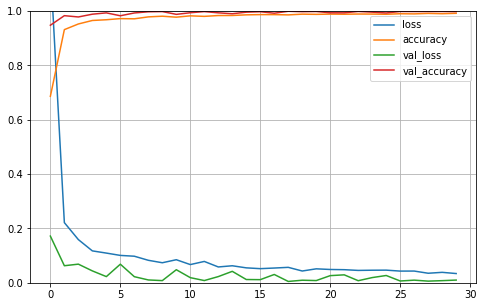

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.99      0.96      0.97       450
           4       1.00      0.98      0.99       660
           5       0.96      1.00      0.98       630
           6       1.00      0.99      1.00       150
           7       1.00      1.00      1.00       450
           8       0.99      0.99      0.99       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.97      0.90      0.94       420
          12       0.99      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       1.00      1.00      1.00       210
          16       0.99      1.00      1.00       150
          17       1.00    

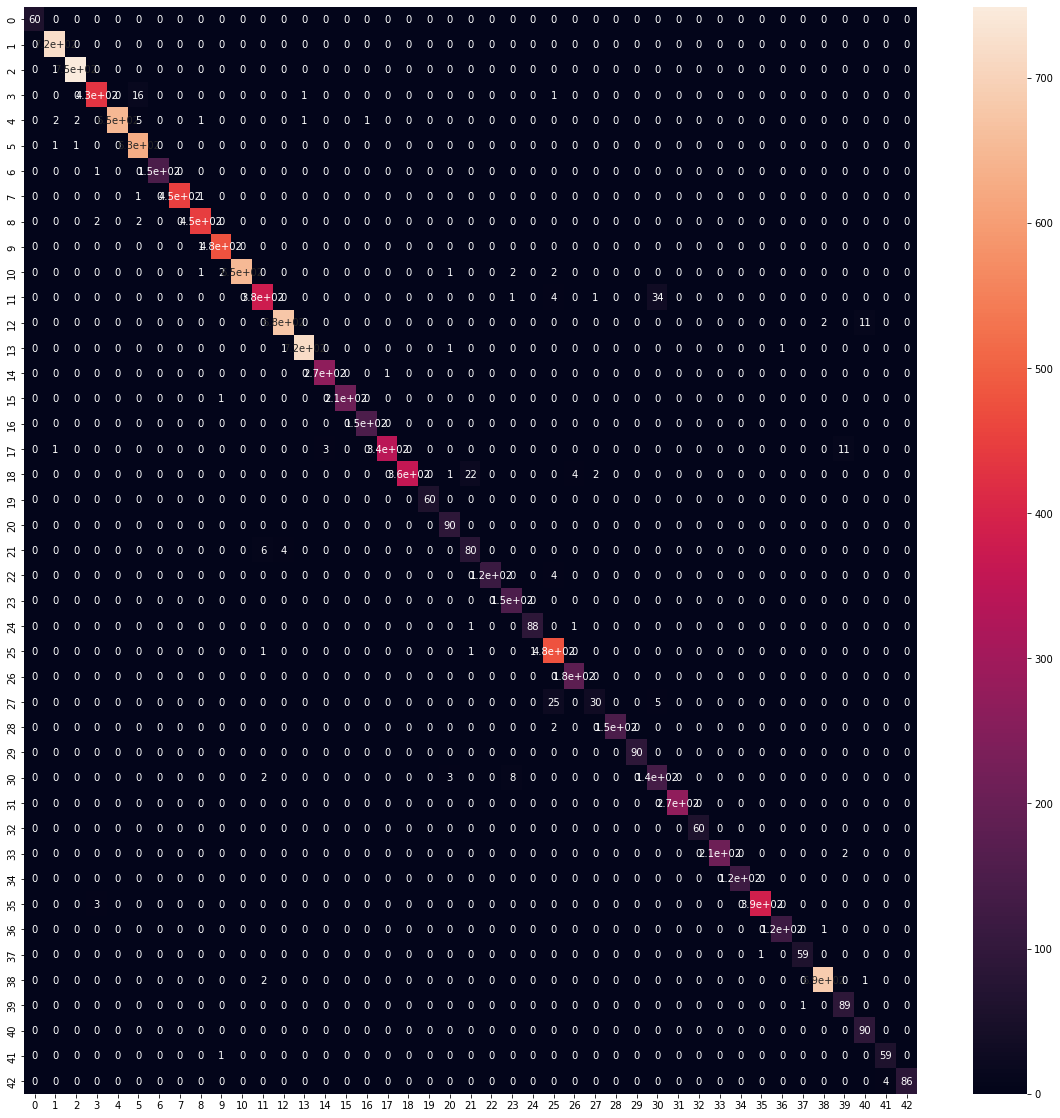

In [81]:
predict= model.predict(X_Test) 
classPred= np.argmax(predict,axis=1)
# Confusion Matrix
from sklearn.metrics import confusion_matrix

df_cm = pd.DataFrame(confusion_matrix(labels, classPred), index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sbn.heatmap(df_cm, annot=True)


print(classification_report(labels, classPred))

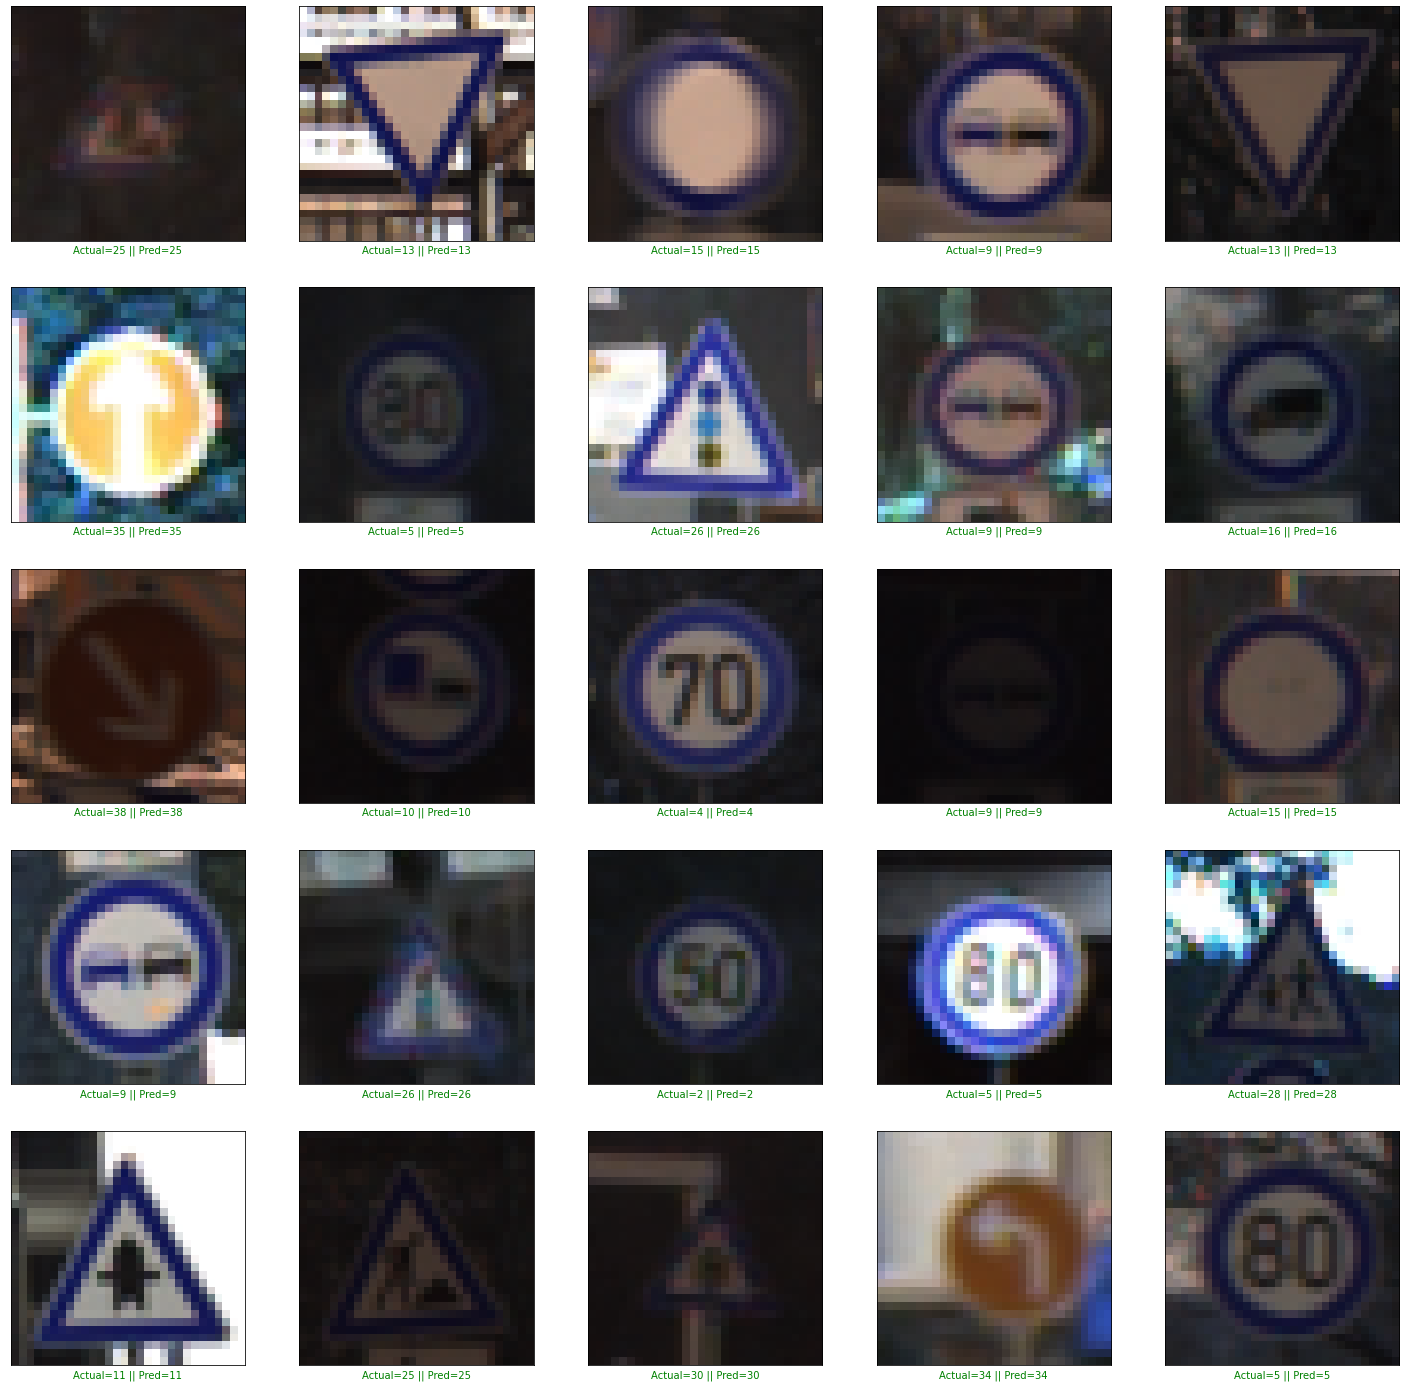

In [79]:
plt.figure(figsize = (25, 25))

start_index = 50
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classPred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_Test[start_index + i])
plt.show()